In [254]:
### Import necessary modules and functions

import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 8

from scipy.stats import norm
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import datasets

import warnings
warnings.filterwarnings('ignore')

# For unix timestamps
from datetime import datetime

In [255]:
### Import the 'KS_train_data.csv' file into a Pandas DataFrame
df = pd.read_csv('KS_train_data.csv',delimiter=',')

In [256]:
### Make functions

# Get continent from country
def GetConti(country):
    if country in UN:
        return "?"
    elif country in AF:
        return "AF"
    elif country in AN:
        return "AN"
    elif country in AS:
        return "AS"
    elif country in EU:
        return "EU"
    elif country in NA:
        return "NA"
    elif country in OC:
        return "OC"
    elif country in SA:
        return "SA"
    else:
        return "other"
    
# Get ratio from (sub)category or country
def GetRatio(name,what):
    if what == 'subcat':
        return subcatRatio[name]
    elif what == 'cat':
        return catRatio[name]
    elif what == 'country':
        return countryRatio[name]
    elif what == 'continent':
        return continentRatio[name]

In [257]:
### Do column stuff

# The imported dataframe's column headers
cols = df.columns

# The removed columns in the testdata
notInTestCols = ['funded', 'pledged', 'usd_pledged', 'converted_pledged_amount', 'backers_count']

# The columns containing unix timestamps
unixcols = ['created_at','deadline', 'launched_at']

# The used cols (in test data set) = cols + extra made
usedCols = list(cols)
usedCols.extend(['category_numeric','country_numeric','continent_numeric','subcatRatio','catRatio','countryRatio','continentRatio'])
usedCols = [x for x in usedCols if x not in notInTestCols[1:5]]

In [258]:
### Necessary lists 

# Africa
AF = ['AO','BF','BI','BJ','BW','CD','CF','CG','CI','CM','CV','DJ','DZ','EG','EH','ER','ET','GA','GH','GM','GN','GQ','GW','KE','KM','LR','LS','LY','MA','MG','ML','MR','MU','MW','MZ','NA','NE','NG','RE','RW','SC','SD','SH','SL','SN','SO','SS','ST','SZ','TD','TG','TN','TZ','UG','YT','ZA','ZM','ZW']

# Antarctica
AN = ['AQ','BV','GS','HM','TF']

# Asia
AS = ['AE','AF','AM','AP','AZ','BD','BH','BN','BT','CC','CN','CX','CY','GE','HK','ID','IL','IN','IO','IQ','IR','JO','JP','KG','KH','KP','KR','KW','KZ','LA','LB','LK','MM','MN','MO','MV','MY','NP','OM','PH','PK','PS','QA','SA','SG','SY','TH','TJ','TL','TM','TW','UZ','VN','YE']

# Europe
EU = ['AD','AL','AT','AX','BA','BE','BG','BY','CH','CZ','DE','DK','EE','ES','EU','FI','FO','FR','FX','GB','GG','GI','GR','HR','HU','IE','IM','IS','IT','JE','LI','LT','LU','LV','MC','MD','ME','MK','MT','NL','NO','PL','PT','RO','RS','RU','SE','SI','SJ','SK','SM','TR','UA','VA','XK']

# North America
NA = ['AG','AI','AN','AW','BB','BL','BM','BS','BZ','CA','CR','CU','DM','DO','GD','GL','GP','GT','HN','HT','JM','KN','KY','LC','MF','MQ','MS','MX','NI','PA','PM','PR','SV','TC','TT','US','VC','VG','VI']

# Oceania
OC = ['AS','AU','CK','FJ','FM','GU','KI','MH','MP','NC','NF','NR','NU','NZ','PF','PG','PN','PW','SB','TK','TO','TV','UM','VU','WF','WS']

# South America
SA = ['AR','AW','BO','BR','BQ','CL','CO','CW', 'EC','FK','GF','GY','PE','PY','SR','SX','UY','VE']

# Unknown Country, Unknown Continent: in case you did for got to run the country code, nan is also here.
UN = ['?',np.nan]

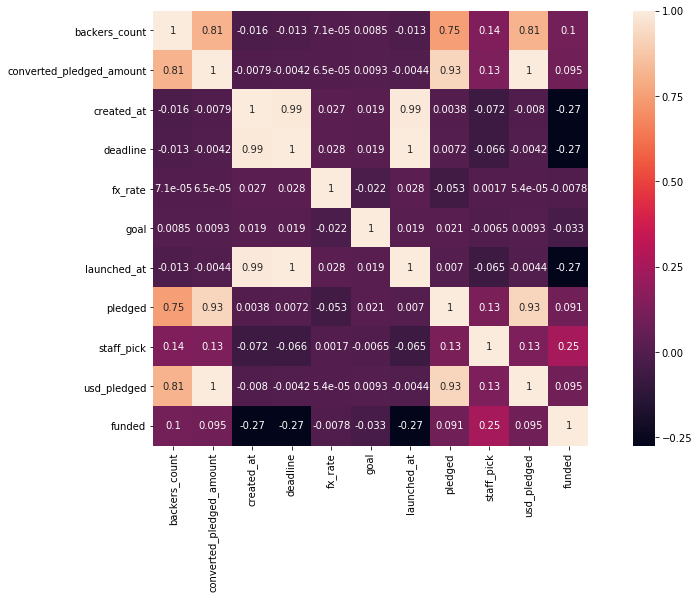

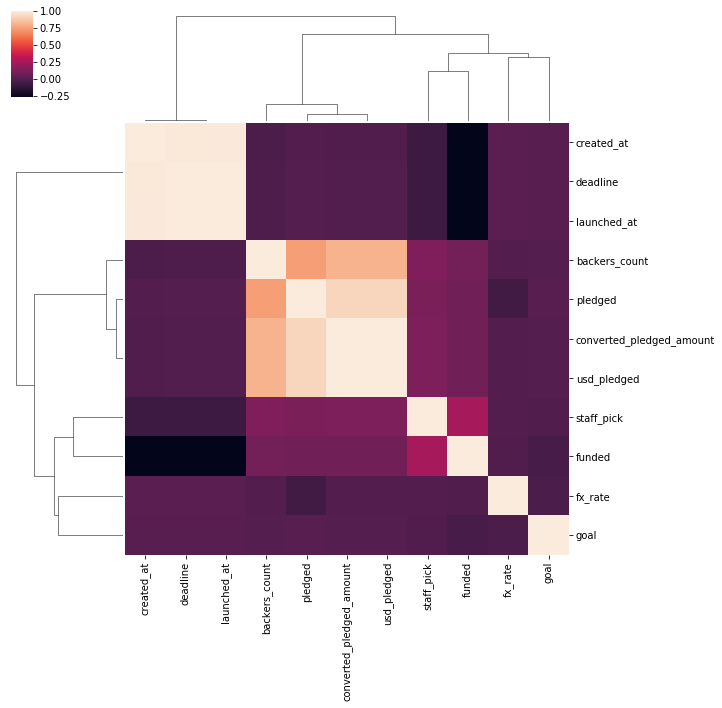

In [259]:
# The Pearson correlation matrix assumes continuous variables.
sns.heatmap(df[cols].corr(), square = True, annot = True);
sns.clustermap(df.corr());

In [260]:
### Handle missing values
#df[cols].isnull().sum()

# Fill in the missing country values
df.loc[df['country'].isnull(),'country']
df['country'] = df['country'].fillna('?');

In [261]:
### Make numeric values

# Make new category_numeric column, represented by a numeric value
df.category = pd.Categorical(df.category)
df['category_numeric'] = df.category.cat.codes

# Make new country_numeric column, represented by a numeric value
df.country = pd.Categorical(df.country)
df['country_numeric'] = df.country.cat.codes

# Make new continent_numeric column, remove unknowns
df['continent_numeric'] = df['country'].apply(lambda x: GetConti(x))

df = df[df.continent_numeric != '?']
df = df[df.continent_numeric != 'other']

df.continent_numeric = pd.Categorical(df.continent_numeric)
df['continent_numeric'] = df.continent_numeric.cat.codes

# Counts the numbers of countries in a continent
#df.groupby('continent_numeric').count()

In [262]:
### Create ratio's

# Funded subcategory / amount in a subcategory
subcat = df.groupby(['subcategory'])['subcategory'].count()
fundedSubcats = df.groupby(['subcategory'])['funded'].sum()
subcatRatio = fundedSubcats/subcat
df['subcatRatio'] = df['subcategory'].apply(lambda x: GetRatio(x,'subcat'))

# Funded category / amount in a category
cat = df.groupby(['category'])['category'].count()
fundedCats = df.groupby(['category'])['funded'].sum()
catRatio = fundedCats/cat
df['catRatio'] = df['category'].apply(lambda x: GetRatio(x,'cat'))

# Funded project in a country / amount of projects in a country
sumProjPerCountry = df.groupby(['country'])['country'].count()
fundedProjPerCountry = df.groupby(['country'])['funded'].sum()
countryRatio = fundedProjPerCountry/sumProjPerCountry
df['countryRatio'] = df['country'].apply(lambda x: GetRatio(x,'country'))

# Funded project in a continent / amount of projects in a continent
sumProjPerContinent = df.groupby(['continent_numeric'])['continent_numeric'].count()
fundedProjPerContinent = df.groupby(['continent_numeric'])['funded'].sum()
continentRatio = fundedProjPerContinent/sumProjPerContinent
df['continentRatio'] = df['continent_numeric'].apply(lambda x: GetRatio(x,'continent'))

# Counts the numbers of countries in a continent
# df.groupby('continent_code').count()

In [263]:
# Investigating '?' countries

#df['continent_code'].isnull()
#df.loc[df['continent_code'].isnull(),'location']
#df.blurb[862]
#843      ?
#847      ?
#851      ?
#852      ?
#853      ?
#856      ?
#858      ?
#862      ?

In [264]:
### UNIX TIMESTAMPS
# unixcols contains unix timestamps (made at the beginning of the file)

df['date_created_at'] = pd.to_datetime(df[unixcols[0]],unit='s')
#df['time_created_at'] =

df['date_deadline'] = pd.to_datetime(df[unixcols[1]],unit='s')
#df['time_deadline'] =

df['date_launched_at'] = pd.to_datetime(df[unixcols[2]],unit='s')
#df['time_launched_at'] =

#timestamp = datetime.datetime.fromtimestamp(1500000000)
#print(timestamp)
#print(timestamp.strftime('%Y-%m-%d %H:%M:%S'))
#datetime.datetime.fromtimestamp(df.deadline[1]).strftime('%Y-%m-%d %H:%M:%S')

In [265]:
#df['date'] = pd.to_datetime(df['deadline'],unit='s')
df.head()

,project_id,backers_count,blurb,category,converted_pledged_amount,country,created_at,currency,deadline,fx_rate,...,category_numeric,country_numeric,continent_numeric,subcatRatio,catRatio,countryRatio,continentRatio,date_created_at,date_deadline,date_launched_at
0,KS_000000,80,I will be an artist-in-residence at Elsewhere ...,art,3596,US,1325980505,USD,1334866560,1.0,...,0,162,4,0.451047,0.557958,0.608791,0.602481,2012-01-07 23:55:05,2012-04-19 20:16:00,2012-03-28 21:14:20
1,KS_000001,82,1000 Artists is a public art-making installati...,art,4586,US,1330926084,USD,1336440145,1.0,...,0,162,4,0.679054,0.557958,0.608791,0.602481,2012-03-05 05:41:24,2012-05-08 01:22:25,2012-03-29 01:22:25
2,KS_000002,21,"The Sequel to ‘My Favorite Machine”, ""MyPhoneH...",art,5217,US,1332382894,USD,1338175739,1.0,...,0,162,4,0.481446,0.557958,0.608791,0.602481,2012-03-22 02:21:34,2012-05-28 03:28:59,2012-03-29 03:28:59
3,KS_000003,37,A film exploring the role and value of art edu...,art,7160,GB,1332342451,USD,1334806096,1.0,...,0,56,3,1.000000,0.557958,0.541360,0.494595,2012-03-21 15:07:31,2012-04-19 03:28:16,2012-03-29 03:28:16
4,KS_000004,153,We need to build a kitchen for Habitable Space...,art,15445,US,1328562617,USD,1335584240,1.0,...,0,162,4,0.679054,0.557958,0.608791,0.602481,2012-02-06 21:10:17,2012-04-28 03:37:20,2012-03-29 03:37:20


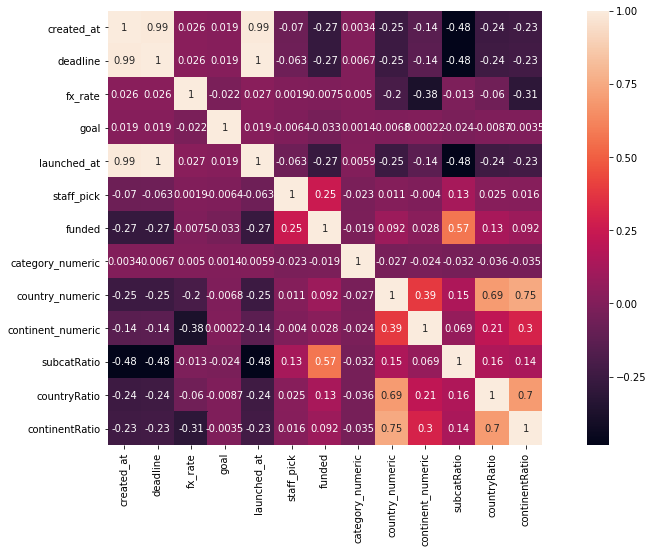

In [266]:
# The Pearson correlation matrix assumes continuous variables.
sns.heatmap(df[usedCols].corr(), square = True, annot = True);
#sns.clustermap(df.corr());